In [0]:
import requests
import json
from collections import Counter
import random
from IPython.display import Image

#import matplotlib.pyplot as plt
#import seaborn as sns

import pandas as pd # data preprocessing
import numpy as np # linear algebra

from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

# Part 1: Train a first Neural Network
Objective: Train a neural network to predict a domain given the title of an item


## Download the dataset
Download the dataset of items and uncompress it

In [157]:
#dataset_url = 'https://drive.google.com/open?id=1Ql0az0GAC1_yHpHsAFvspKt1HZGMZOOa'

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


download_file_from_google_drive('1kSPUjkf7gkB77UVTNnIW_cmGIjsa7GSh', 'arq.png')                
download_file_from_google_drive('1lD7fMlzNhx0AaPkoksrqJ4HEiTL_u5KM', 'vec.png')
#!unzip 'dataset.zip'

download_file_from_google_drive('1Ql0az0GAC1_yHpHsAFvspKt1HZGMZOOa', 'cellphones.zip')
!unzip 'cellphones.zip'

Archive:  cellphones.zip
replace cellphones.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cellphones.csv          


Here is the architecture of the Neural Network that we are going to train

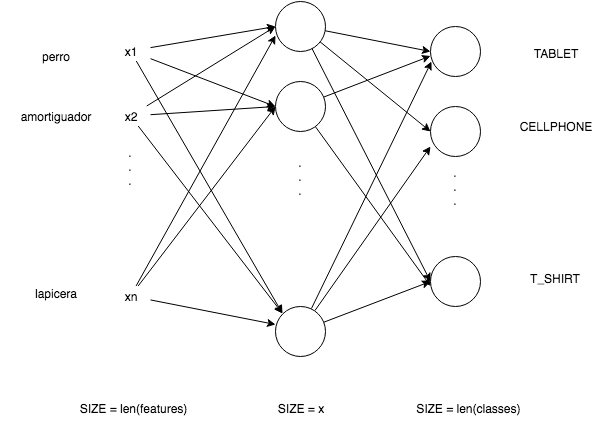

In [158]:
display(Image('arq.png'))

## Load the dataset using pandas
The dataset is a csv , the csv is separated using tabs

See: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [0]:
def read_csv(path='cellphones.csv'):
  return pd.read_csv(path, sep='\t')

In [0]:
df = read_csv()

## Explore the data

Let's do some checks to see if the data makes sense

In [161]:
df.head()

,Unnamed: 0,item_id,title,domain_id
0,201,MLA691173446,Flex Pin De Carga Iphone Se Jack Instalación Gratis,CELLPHONE_AND_TABLET_FLEX_CABLES
1,289,MLA670542324,Flex Pin De Carga Microfono Samsung A5 2016 Sm-a510 Ver: M,CELLPHONE_AND_TABLET_FLEX_CABLES
2,328,MLA701436095,Impresora Fotográfica Inyección De Tinta Canon Pixma Ip7210,CELLPHONE_PRINTERS
3,426,MLA753195120,Para Microsoft Lumia 950 Xl Altavoz Oido,CELLPHONE_REPLACEMENT_SPEAKERS
4,448,MLA763947212,Nuevo Apple Iphone Xs Max,CELLPHONE_SELFIE_LIGHTS


First, find how many classes we have in the dataset. This classes will be the output of the Neural Network

In [0]:
def get_num_classes(df):
  return len(df.domain_id.unique())

In [163]:
num_classes = get_num_classes(df)
print("Número de classes:", num_classes)
print("Número de ejemplos:", len(df))

Número de classes: 25
Número de ejemplos: 62661


Count how many items we have per class and:
 1. Make a line plot
 2. Plot a histogram distribution
 
 This will help us understand how balanced is our dataset

(0, 5500)

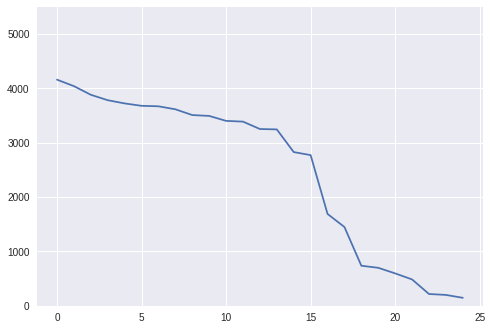

In [164]:
plt = (df.groupby('domain_id')
             .count()
             .sort_values('title', ascending=False)
             .reset_index()[['domain_id','title']]
             .rename(columns={"title":"counts"}))['counts'].plot.line()
plt.set_ylim(0,5500)

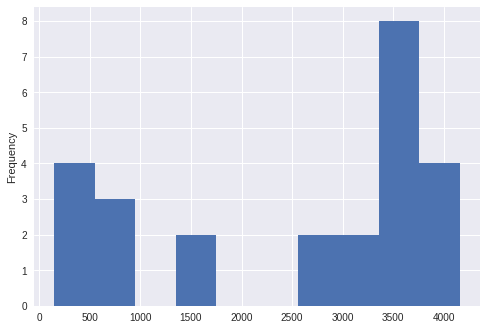

In [165]:
(df.groupby('domain_id')
             .count()
             .reset_index()[['domain_id','title']]
             .rename(columns={"title":"counts"}))['counts'].plot.hist()

A note on skewed distributions

## Prepare the data

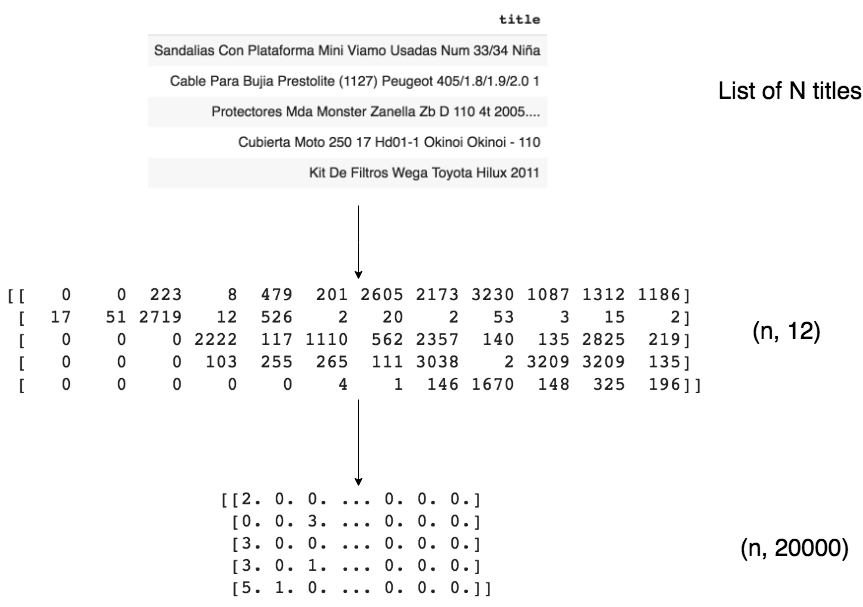

In [166]:
display(Image('vec.png'))

### Tokenization


Fit a tokenizer that we will use to vectorize the examples.

1.   Create a tokenizer
  1. Parameters: Number of features, etc.. (how to split, lowercase, etc)
2.   Fit that tokenizer using the corpus (All the titles in the dataset)


**From** https://keras.io/preprocessing/text/:

This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...


In [0]:
def build_tokenizer(corpus, num_features=5000):
  tokenizer = text.Tokenizer(num_words=num_features, lower=True, split=' ')
  tokenizer.fit_on_texts(corpus)
  return tokenizer
  

In [177]:
import time
tic = time.time()
num_features=5000
tokenizer = build_tokenizer(df['title'].values, num_features)

toc = time.time()    
print("Time to create tokenizer: " + str(1000*(toc-tic)) + " ms")


Time to create tokenizer: 1331.4707279205322 ms


A tokenizer has the following properties

**word_counts**: ordereddict("word": "count")

**word_docs**: dic("word": "count docs it appears")

**word_index**: Vocabulary dict("word":index)

**document_count**:int #doc used to fit the Tokenizer.

In [0]:
#print(tokenizer.word_counts)
#print(tokenizer.word_counts)
#print(tokenizer.word_index)
#print(tokenizer.document_count)
#print(tokenizer.word_docs)

### Vectorization



This builds the word vocabulary. It shoud return a dictionary with the following format: 

{..., 1: "con", 2: "tablet", ...}

Note: use tokenizer.word_index

In [0]:
def build_idx_to_word(tokenizer):
  return {idx:tkn for tkn, idx in tokenizer.word_index.items()}


This function returns a sequence of indices representing the text

See https://keras.io/preprocessing/sequence/:

sequence.pad_sequences

use: tokenizer.texts_to_sequences(text)

In [0]:
'''
text: list of titles
max_seq_length: fixed length to the titles. 
  If the title has more than "max_seq_length" tokens => truncate it to max_seq_length
  If the title has less than "max_seq_length" tokens => complete at the begining with 0's 
'''
def vectorize_text(text, tokenizer, max_seq_length=12):  
  text_sequences = tokenizer.texts_to_sequences(text)

  text_sequences = sequence.pad_sequences(text_sequences, maxlen=max_seq_length)
  
  return text_sequences

Explore generated features

Try using the modes "count" and "tfidf" to see the difference

In [181]:
title = "tablet samsung de tablet con para pantalla tablet"
print(title)

text_sequences = vectorize_text([title], tokenizer)
assert text_sequences.shape == (1,12)

encoded_docs = tokenizer.sequences_to_matrix(text_sequences.tolist(), mode="tfidf")
assert encoded_docs.shape == (1, num_features)

idx_tkn = build_idx_to_word(tokenizer)
for tkn in set(text_sequences[0]):
  if tkn > 0:
    print(idx_tkn[tkn] ,encoded_docs[0][tkn])


tablet samsung de tablet con para pantalla tablet
samsung 1.6493240697185012
para 1.8794853335542474
de 2.0584739870189463
tablet 9.737773426323647
con 2.989402038865097
pantalla 3.1143238955252452


#### Vectorize the labels

This function append a new column called "label" with an integer that uniquely identify that domain_id.
See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html


In [0]:
def vectorize_labels(df):
  df['label'] = df['domain_id'].factorize()[0]

We will be using categorical_crossentropy loss function (softmax), for this reason, we need to use one_hot encoding for our labels.

The representation should look like: [0, 0, ..., 1, 0] sparse vector with a "1" in the position of the target label.
  
  See https://keras.io/utils/ (to_categorial function)

In [0]:
from tensorflow.python.keras.utils import to_categorical

def encode_labels(labels):
  # Convert labels to categorical one-hot encoding
  one_hot_labels = to_categorical(labels, len(set(labels)))
  return one_hot_labels

This builds the labels vocabulary. It shoud return a dictionary with the following format: 
{..., 1: "TABLETS", 2: "CELLPHONES", ...}

In [0]:
def build_idx_to_label(df):
  idx_to_label = {idx:domain_id for domain_id, idx in df.groupby(['domain_id', 'label']).groups.keys()}
  return idx_to_label


Check that all the training examples belonging to the same domain have the same vectorizer label

In [185]:
vectorize_labels(df)  
idx_to_label = build_idx_to_label(df)

assert df[df['label']==3].reset_index().iloc[0]['domain_id'] == idx_to_label[3]
df.head()

labels = encode_labels(df['label'].values)
print(df.iloc[10]['domain_id'], df.iloc[10]['label'], idx_to_label[df.iloc[10]['label']])
assert labels[0][df.iloc[0]['label']] == 1 

CAMERA_AND_CELLPHONE_STABILIZERS 7 CAMERA_AND_CELLPHONE_STABILIZERS


### Vectorization using scikit learn

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 5000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)
    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    print("Length of vocabulary:", len(vectorizer.get_feature_names()))
    
    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

### Split the dataset in Train, Dev and Test sets

NOTE: Remember to always random shuffle the dataset before splitting it.

See:

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html


In [0]:
train_size = int(len(df)*0.7)
dev_size = int(train_size*0.2)
test_size = int(train_size*0.1)

In [0]:
def split_dataset(df, train_size=10000, dev_size=1000, test_size=1000):
  # Random shuffle the dataset rows
  df = df.sample(frac=1).reset_index(drop=True)
  df_train = df[:train_size].reset_index(drop=True)
  df_dev = df[train_size:(train_size+dev_size)].reset_index(drop=True)
  df_test = df[(train_size + dev_size):(train_size + dev_size + test_size)].reset_index(drop=True)
  return df_train, df_dev, df_test

In [0]:
df_train, df_dev, df_test = split_dataset(df, train_size, dev_size, test_size)
assert len(df_train) == train_size
assert len(df_dev) == dev_size
assert len(df_test) == test_size

Finally, create the encoder for the different sets

In [279]:
x_train_encoded, x_dev_encoded = ngram_vectorize(df_train['title'].values, df_train['label'].values, df_dev['title'].values)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1569: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Length of vocabulary: 31810


In [277]:
x_train.shape

(30000, 12)

In [0]:
x_train = vectorize_text(df_train['title'].values, tokenizer)
x_train_encoded = tokenizer.sequences_to_matrix(x_train.tolist(), mode="tfidf")
y_train_encoded = to_categorical(df_train['label'].values, len(df.domain_id.unique()))

x_dev = vectorize_text(df_dev['title'].values, tokenizer)
x_dev_encoded = tokenizer.sequences_to_matrix(x_dev.tolist(), mode="tfidf")
y_dev_encoded = to_categorical(df_dev['label'].values, len(df.domain_id.unique()))

x_test = vectorize_text(df_test['title'].values, tokenizer)
x_test_encoded = tokenizer.sequences_to_matrix(x_test.tolist(), mode="tfidf")
y_test_encoded = to_categorical(df_test['label'].values, len(df.domain_id.unique()))

In [253]:
print(x_train_encoded.shape)
print(y_train_encoded.shape)


(30000, 20000)
(30000, 25)


In [192]:
index = 45
print(df_train.iloc[index])
print(y_train_encoded[index])
print(idx_to_label[df_train.iloc[index]['label']])
assert y_train_encoded[index][df_train.iloc[index]['label']] == 1.


Unnamed: 0    5194896                                                   
item_id       MLA672110892                                              
title         Impresora De Fotos Instantáneas Fujifilm Instax Share Sp-2
domain_id     CELLPHONE_PRINTERS                                        
label         1                                                         
Name: 45, dtype: object
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
CELLPHONE_PRINTERS


## Build the model

We will first create a model using Keras Sequential API

Learn More: https://keras.io/getting-started/sequential-model-guide/

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation

def build_model(num_features, num_classes):
  model = Sequential([
      Dense(512, input_shape=(num_features,), activation='relu'),
      Dense(num_classes, activation='softmax'),
  ])

  # For a multi-class classification problem
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [0]:
model = build_model(x_train_encoded.shape[1], y_train_encoded.shape[1])

### Visualizing the Neural Network

In [195]:
# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 1024)              20481024  
_________________________________________________________________
dense_23 (Dense)             (None, 25)                25625     
Total params: 20,506,649
Trainable params: 20,506,649
Non-trainable params: 0
_________________________________________________________________
None


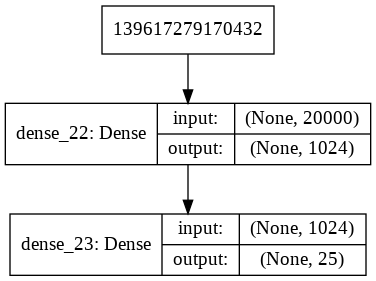

In [244]:
from keras.utils import plot_model

# Model summary
print(model.summary())

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
display(Image('model.png'))

## Train the model

It is time to train the model

See: https://keras.io/models/model/ (fit function)

In [282]:
from tensorflow.keras.callbacks import EarlyStopping
# Create callback for early stopping on validation loss. If the loss does
# not decrease in two consecutive tries, stop training.
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

# Train and validate model.
history = model.fit(
    x_train_encoded,
    y_train_encoded,
    callbacks=callbacks,
    epochs=20,
    validation_data=(x_dev_encoded, y_dev_encoded),
    verbose=1,  # Logs once per epoch.
    batch_size=128)

Train on 43862 samples, validate on 8772 samples
Epoch 1/20
43862/43862 [==============================] - 4s 93us/sample - loss: 0.9843 - acc: 0.8506 - val_loss: 0.3886 - val_acc: 0.9033
Epoch 2/20
43862/43862 [==============================] - 3s 76us/sample - loss: 0.3113 - acc: 0.9201 - val_loss: 0.3383 - val_acc: 0.9106
Epoch 3/20
43862/43862 [==============================] - 3s 76us/sample - loss: 0.2515 - acc: 0.9316 - val_loss: 0.3339 - val_acc: 0.9107
Epoch 4/20
43862/43862 [==============================] - 3s 76us/sample - loss: 0.2190 - acc: 0.9377 - val_loss: 0.3314 - val_acc: 0.9134
Epoch 5/20
43862/43862 [==============================] - 3s 76us/sample - loss: 0.1956 - acc: 0.9420 - val_loss: 0.3388 - val_acc: 0.9115
Epoch 6/20
43862/43862 [==============================] - 3s 76us/sample - loss: 0.1786 - acc: 0.9460 - val_loss: 0.3433 - val_acc: 0.9104
Epoch 7/20
43862/43862 [==============================] - 3s 75us/sample - loss: 0.1652 - acc: 0.9490 - val_loss: 0.3

### Visualizing learning curve

In [0]:
import matplotlib.pyplot as plt

def visualize_training_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

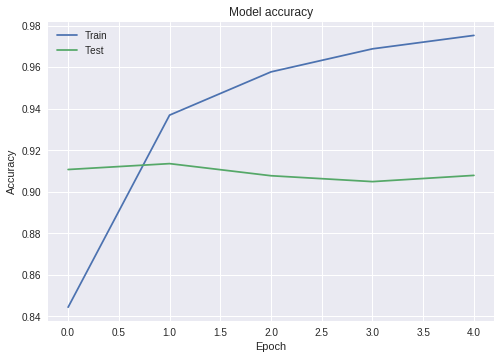

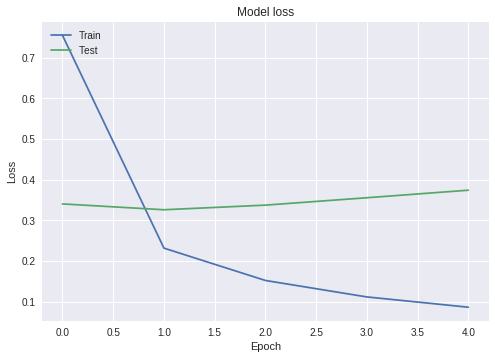

In [199]:
visualize_training_history(history)

## Evaluate the model on the test set

In [0]:
y_pred_test = model.predict(x_test_encoded)

In [201]:
y_pred_test.shape


(6000, 25)

### Visualize the Confusion Matrix

In [109]:
# https://github.com/sepandhaghighi/pycm
!pip install pycm==1.8

In [0]:
from pycm import *

y_pred = np.argmax(y_pred_test, axis=1)
y_act = np.argmax(y_test_encoded, axis=1)

cm = ConfusionMatrix(actual_vector=y_act, predict_vector=y_pred)

In [203]:
cm.print_matrix()
#cm.print_normalized_matrix()
#print(idx_to_label[2], len(df_test[df_test['domain_id']==idx_to_label[2]]))
#cm.print_matrix(one_vs_all=True, class_name=2)

Predict          0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15     16     17     18     19     20     21     22     23     24     
Actual
0                380    0      5      0      1      0      0      0      2      2      0      0      1      11     0      0      0      1      2      0      0      0      4      0      0      

1                0      162    0      0      0      1      0      0      3      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      

2                2      0      315    0      3      1      0      1      1      2      1      1      4      0      1      0      0      0      1      0      0      0      0      1      0      

3                0      0      0      38     0      2      0      0      0      0      0      0      1      0      0      1      0      0      1      0      0      0      0      0      0      

4                1      

In [0]:
def print_errors(df_s, y_act, y_pred, idx_to_label, class_label=None, pred_label=None):
  for idx, row in df_s.iterrows():
    if class_label is not None and pred_label is not None:
      if y_act[idx] != y_pred[idx] and row['label']==class_label and y_pred[idx] == pred_label:
        print(row['item_id'], row['title'], 'Truth:', row['domain_id'], 'Prediction:',idx_to_label[y_pred[idx]])
    else:
      if y_act[idx] != y_pred[idx]:
        print(row['item_id'], row['title'], 'Truth:', row['domain_id'], 'Prediction:',idx_to_label[y_pred[idx]])

In [205]:
print("Y_act", y_act[:10])
print("Y_pred",y_pred[:10])
print("Title:", df_test.iloc[0]['title'])
print(df_test.iloc[0]['domain_id'], idx_to_label[y_pred[0]])
assert df_test.iloc[0]['domain_id'] == idx_to_label[y_pred[0]]


Y_act [ 9 14 13  2  2 13  0 16  5  5]
Y_pred [ 9 14 13  2  2 13  0 16  5  5]
Title: Placa Madre Y Repuestos Alcatel Pop S3
CELLPHONE_MOTHERBOARDS CELLPHONE_MOTHERBOARDS


In [230]:
print_errors(df_test, y_act, y_pred, idx_to_label, 0, 13)

MLA735397952 Módulo De Cámara Grande Oem Flex Cable Cinta Trasera Trasera Truth: CELLPHONE_AND_TABLET_FLEX_CABLES Prediction: CELLPHONE_REPLACEMENT_CAMERAS
MLA640800070 Vibrador Del Samsung Galaxy S3 I9300 Colocado Truth: CELLPHONE_AND_TABLET_FLEX_CABLES Prediction: CELLPHONE_REPLACEMENT_CAMERAS
MLA703016925 Flex Camara Delantera Repuesto Samsung Tab N8000 Centro Truth: CELLPHONE_AND_TABLET_FLEX_CABLES Prediction: CELLPHONE_REPLACEMENT_CAMERAS
MLA752516493 Frente Camara Reemplazo Para Htc Uno M9 Truth: CELLPHONE_AND_TABLET_FLEX_CABLES Prediction: CELLPHONE_REPLACEMENT_CAMERAS
MLA641459384 Camara Repuesto Con Flex Samsung S5230 Truth: CELLPHONE_AND_TABLET_FLEX_CABLES Prediction: CELLPHONE_REPLACEMENT_CAMERAS
MLA763257524 Sensor De Prox/cam Frontal Iphone 7 Plus Instalacion S/cargo Truth: CELLPHONE_AND_TABLET_FLEX_CABLES Prediction: CELLPHONE_REPLACEMENT_CAMERAS
MLA693652916 Vibrador Lg G4 H815 Original Sin Colocar Truth: CELLPHONE_AND_TABLET_FLEX_CABLES Prediction: CELLPHONE_REPLACEMENT

## Prepare the data (with love)

We will use Natural Language Toolkit to make same preprocessing to the data.

See: https://www.nltk.org/

In [119]:
!pip install nltk

In [0]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
import matplotlib.pyplot as plt

def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50,
                                         reverse=True):
    """Plots the frequency distribution of n-grams.

    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': ngram_range,
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=reverse)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(9,8))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=90)
    plt.show()

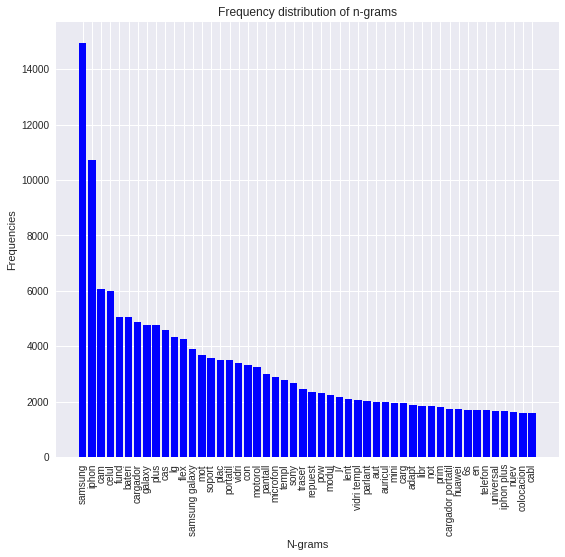

In [233]:

plot_frequency_distribution_of_ngrams(df['title'].values, reverse=True)

In [0]:
import nltk
import unicodedata
import re

SPACES = re.compile(r"\s+")
WORD = re.compile(r"\w+")

stop_phrases = [
    "de(l)?",
    "original(es)?",
    "para",
    "envios? (gratis|a domicilios|a todo el pais)?",
    "((muy)? poco|sin) uso?",
    "instalacion(es)? (gratis|sin costo|sin cargo|s/cargo|c/ cargo)",
    "(como|igual a|casi) nuevos?",
    "(consult(e|a|ar)|consultar|hay|con|en) stock",
    "(buen|impecable|inmejorable) estado"
]

In [210]:
# 2 - Remove stopwords
title = "celular iphone 6 sin uso envio a todo el pais instalacion sin cargo como nuevos consultar stock"
for stopword in stop_phrases:
  stopword_reg = re.compile(r'\b{}\b'.format(stopword))
  title = stopword_reg.sub('', title)
print(title)  
#print(re.compile(r'\b{}\b'.format("(conuslte|conusltar|hay|con|en) stock")).sub('', title))

celular iphone 6     


In [211]:
from nltk.stem import SnowballStemmer
print(" ".join(SnowballStemmer.languages)) 
stemmer = SnowballStemmer("spanish")

def strip_accents(text):
    normalized = unicodedata.normalize('NFKD', text)
    only_ascii = normalized.encode('ascii', 'ignore').decode('utf-8')
    return only_ascii
  
def remove_unuseful_tokens(text):
  
    return " ".join(WORD.findall(text.replace('_', ' ')))
  
def clean_data(row):
    # 1 - Text to lower
    title = row['title'].lower()

    title = SPACES.sub(' ', title) 

    title = remove_unuseful_tokens(title)

    # 2 - Remove stopwords
    for stopword in stop_phrases:
      stopword_reg = re.compile(r'\b{}\b'.format(stopword))
      title = stopword_reg.sub('', title)

    # 3 - Remove accents
    title = strip_accents(title)

    # 4 - Stem the words
    tokens = [stemmer.stem(t) for t in title.split()]
    row['original_title'] = row['title']
    row['title'] = " ".join(tokens)
    return row

arabic danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


In [212]:
tic = time.time()

df = df.apply(clean_data, axis=1)

toc = time.time()    
print("Time to clean text: " + str(1000*(toc-tic)) + " ms")


df.head()

Time to clean text: 78106.6198348999 ms


,Unnamed: 0,item_id,title,domain_id,label,original_title
0,201,MLA691173446,flex pin carg iphon se jack instalacion gratis,CELLPHONE_AND_TABLET_FLEX_CABLES,0,Flex Pin De Carga Iphone Se Jack Instalación Gratis
1,289,MLA670542324,flex pin carg microfon samsung a5 2016 sm a510 ver m,CELLPHONE_AND_TABLET_FLEX_CABLES,0,Flex Pin De Carga Microfono Samsung A5 2016 Sm-a510 Ver: M
2,328,MLA701436095,impresor fotograf inyeccion tint canon pixm ip7210,CELLPHONE_PRINTERS,1,Impresora Fotográfica Inyección De Tinta Canon Pixma Ip7210
3,426,MLA753195120,microsoft lumi 950 xl altavoz oid,CELLPHONE_REPLACEMENT_SPEAKERS,2,Para Microsoft Lumia 950 Xl Altavoz Oido
4,448,MLA763947212,nuev apple iphon xs max,CELLPHONE_SELFIE_LIGHTS,3,Nuevo Apple Iphone Xs Max


In [127]:
df.tail()

,Unnamed: 0,item_id,title,domain_id,label,original_title
62656,5505945,MLA654401370,conversor ojo pez cam digital o celul,CELLPHONE_CAMERA_ATTACHMENTS,5,Conversor Ojo De Pez Camara Digital O Celular
62657,5505948,MLA737553760,limpiador gel uv pegament lcd display celul modul,CELLPHONE_AND_TABLET_LCD_SCREENS,18,Limpiador De Gel Uv Pegamento Lcd Display Celular Modulo
62658,5505971,MLA746248087,huawei mat 10 lit,CELLPHONES,14,Huawei Mate 10 Lite
62659,5506040,MLA695165545,bateri only smartphon sony m5,CELLPHONE_BATTERIES,11,Baterias Only Para Smartphone - Sony M5
62660,5506048,MLA711916686,fund celul s4msung galaxy s5 mini g800f soft abr,CELLPHONE_COVERS,17,Funda Celular S4msung Galaxy S5 Mini G800f Soft Abr


# Part 2: Recurrent Neural Network

In [214]:
print(x_train.shape)
print(y_train_encoded.shape)


title = "tablet samsung de tablet con para pantalla tablet"
print(title)

text_sequences = vectorize_text([title], tokenizer)
assert text_sequences.shape == (1,12)

#encoded_docs = tokenizer.sequences_to_matrix(text_sequences.tolist(), mode="binary")
#print(encoded_docs.shape)
#assert encoded_docs.shape == (1,12, 20000)

#idx_tkn = build_idx_to_word(tokenizer)
#for tkn in set(text_sequences[0]):
#  if tkn > 0:
#    print(idx_tkn[tkn] ,encoded_docs[0][tkn])

(30000, 12)
(30000, 25)
tablet samsung de tablet con para pantalla tablet


## RNN using embedding Layer

In [226]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout, LSTM, Embedding, Masking
from tensorflow.keras.optimizers import RMSprop, Adam
                         
num_features = x_train_encoded.shape[1]
title_max_length = x_train.shape[1]

rnn_model = Sequential([
    Embedding(input_dim=num_features,
              output_dim=200,
              input_length=title_max_length),
    LSTM(units=256, return_sequences=True),
    Dropout(0.5),
    LSTM(units=256),
    Dropout(0.5),
    Dense(len(df.domain_id.unique()), activation='softmax')
])

# For a multi-class classification problem
rnn_model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train and validate model.
history = rnn_model.fit(
    x_train,
    y_train_encoded,
    epochs=40,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    validation_data=(x_dev, y_dev_encoded),
    verbose=1,  # Logs once per epoch.
    batch_size=256)

Train on 30000 samples, validate on 6000 samples
Epoch 1/40
30000/30000 [==============================] - 12s 396us/sample - loss: 1.6090 - acc: 0.5415 - val_loss: 0.5062 - val_acc: 0.8628
Epoch 2/40
30000/30000 [==============================] - 10s 337us/sample - loss: 0.4420 - acc: 0.8888 - val_loss: 0.4003 - val_acc: 0.8945
Epoch 3/40
30000/30000 [==============================] - 10s 336us/sample - loss: 0.3190 - acc: 0.9172 - val_loss: 0.3808 - val_acc: 0.9007
Epoch 4/40
30000/30000 [==============================] - 10s 335us/sample - loss: 0.2621 - acc: 0.9302 - val_loss: 0.3833 - val_acc: 0.9055
Epoch 5/40
30000/30000 [==============================] - 10s 337us/sample - loss: 0.2253 - acc: 0.9396 - val_loss: 0.4219 - val_acc: 0.8985
Epoch 6/40
30000/30000 [==============================] - 10s 337us/sample - loss: 0.1965 - acc: 0.9466 - val_loss: 0.4171 - val_acc: 0.9045


## Visualize Word Embeddings

In [219]:
!pip install ggplot

from sklearn.manifold import TSNE
from ggplot import *


embedding_model = Sequential([
    Embedding(input_dim=num_features,
              output_dim=200,
              input_length=title_max_length,
              weights=rnn_model.layers[0].get_weights())
])

def get_embeddings(titles, flatten=False):
    seq = tokenizer.texts_to_sequences(titles)
    max_sentence_length = 12
    padded = sequence.pad_sequences(seq, max_sentence_length)
    prediction = embedding_model.predict(padded)
    
    if flatten:
        return [np.ndarray.flatten(e) for e in prediction]
    
    return prediction

    100% |████████████████████████████████| 2.2MB 11.6MB/s 


/usr/local/lib/python3.6/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python3.6/dist-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
def visualize_embeddings(x_titles):

  np.random.shuffle(x_titles)

  perplexity = 14

  emb_titles = np.array(get_embeddings(x_titles, flatten=True))

  X_embedded = TSNE(n_components=2 , perplexity=perplexity, init='pca', random_state=8).fit_transform(emb_titles)

  fig, ax = plt.subplots(figsize=(14,14), dpi=100)
  vis_x = X_embedded[:, 0]
  vis_y = X_embedded[:, 1]
  sc = ax.scatter(vis_x, vis_y, c = np.array(range(len(vis_y))), cmap=plt.cm.get_cmap("jet", 10))
  fig.show()

  max_label_length = 30

  for i in range(len(vis_y)):
      annot = ax.annotate(x_titles[i][: max_label_length], (vis_x[i], vis_y[i]))

In [0]:
#list(tokenizer.word_counts)[:100]

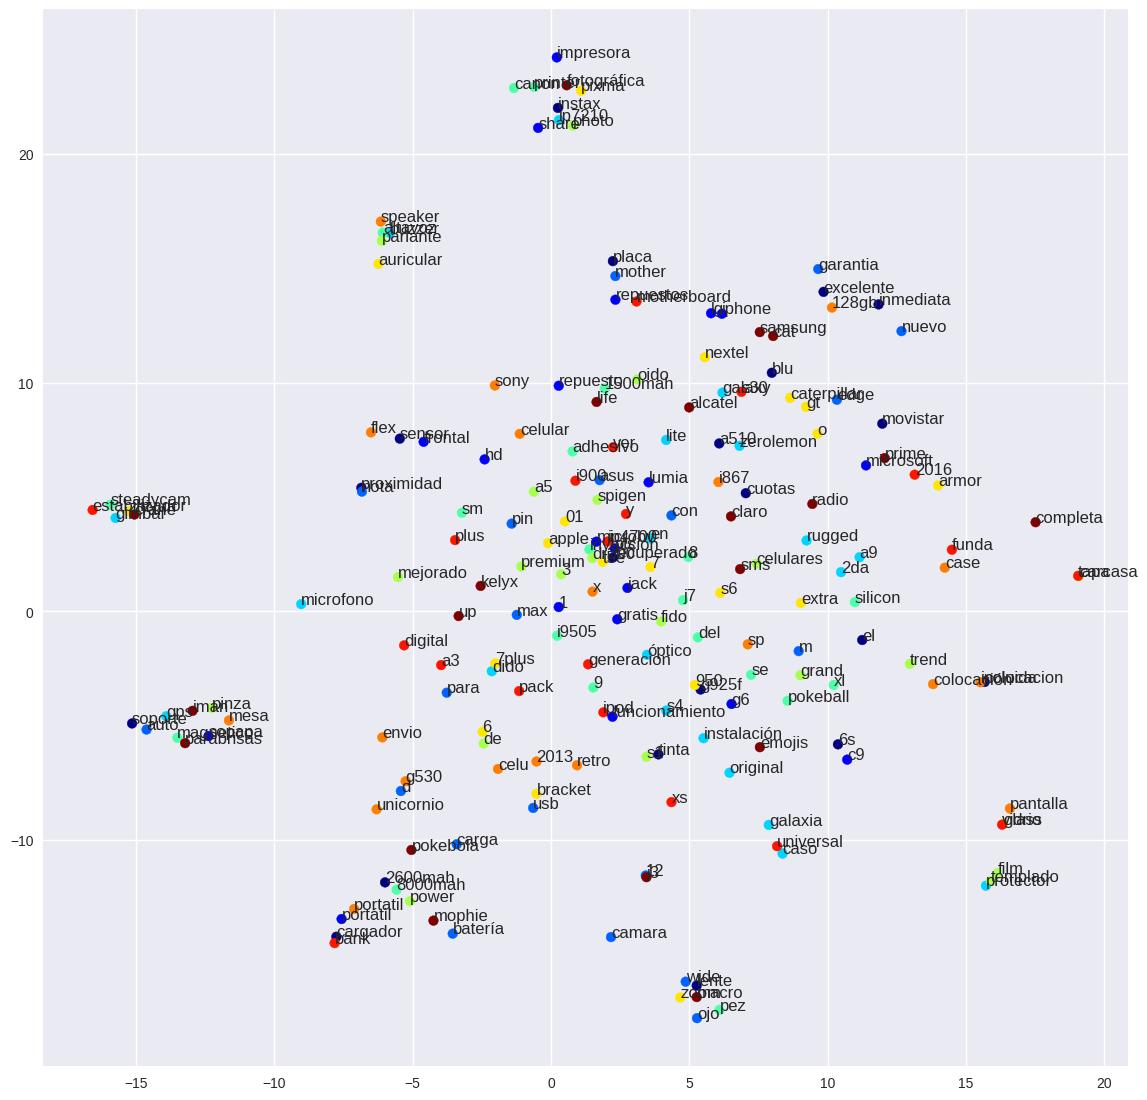

In [222]:
  x_titles = list(tokenizer.word_counts)[:200]
  
  visualize_embeddings(x_titles)